<a href="https://colab.research.google.com/github/kundajelab/gkmexplain/blob/master/lsgkmexplain_TALGATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install lsgkm
!rm -rf lsgkm
! git clone https://github.com/kundajelab/lsgkm
% cd lsgkm/src
! make
! ./gkmtrain
%cd ../..

Cloning into 'lsgkm'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 293 (delta 0), reused 1 (delta 0), pack-reused 289
Receiving objects: 100% (293/293), 489.52 KiB | 1.90 MiB/s, done.
Resolving deltas: 100% (196/196), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmpredict.c libsvm.o libsvm_gkm.o -o gkmpredict -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmexplain.c libsvm.o libsvm_gkm.o -o gkmexplain -lm -lpthread

Usage: gkmtrain [options] <posfile> <negfile> <outprefix>

 train gkm-SVM using libSVM

Arguments:
 posfile: positive sequence file (FASTA format)
 negfile: negative sequence file (FASTA format)
 outprefix: prefix of output file(s) <outprefix>.model.txt or
            <outpre

In [2]:
#get the raw data
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/master/deeplift/genomics/sequences.simdata.gz

--2019-01-28 00:06:00--  https://raw.githubusercontent.com/AvantiShri/model_storage/master/deeplift/genomics/sequences.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629502 (615K) [application/octet-stream]
Saving to: ‘sequences.simdata.gz’

sequences.simdata.g 100%[===================>] 614.75K  --.-KB/s    in 0.04s   

2019-01-28 00:06:00 (17.0 MB/s) - ‘sequences.simdata.gz’ saved [629502/629502]



In [3]:
!zcat sequences.simdata | head

seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATATAAAATAGTAGTAA

In [0]:
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "1") {print ">$F[0]\n$F[1]"}' > positives.fa
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "0") {print ">$F[0]\n$F[1]"}' > negatives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' positives.fa > test_positives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' positives.fa > train_positives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' negatives.fa > test_negatives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' negatives.fa > train_negatives.fa

In [5]:
!wc -l *.fa

  12000 negatives.fa
   4000 positives.fa
   2400 test_negatives.fa
    800 test_positives.fa
   9600 train_negatives.fa
   3200 train_positives.fa
  32000 total


In [6]:
import time

t=3
c=10
g=2
l=6
k=5
d=1

!lsgkm/src/gkmtrain -t $t -c $c -g $g -l $l -k $k -d $d -w 3 train_positives.fa train_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3"


start = time.time()
!lsgkm/src/gkmpredict test_positives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_positives.txt
end = time.time()
print("Time taken per seq:",(end-start)/400)
start = time.time()
!lsgkm/src/gkmpredict test_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_negatives.txt
end = time.time()
print("Time taken per seq:",(end-start)/1200)

import numpy as np
from sklearn.metrics import roc_auc_score
pos_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_positives.txt")]
neg_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_negatives.txt")]
print(roc_auc_score(y_true=np.array([1 for i in range(len(pos_preds))]+[0 for i in range(len(neg_preds))]),
                    y_score=np.array(pos_preds+neg_preds)))

INFO 2019-01-28 00:06:26: Number of threads is set to 1
INFO 2019-01-28 00:06:26: Arguments:
INFO 2019-01-28 00:06:26:   posfile = train_positives.fa
INFO 2019-01-28 00:06:26:   negfile = train_negatives.fa
INFO 2019-01-28 00:06:26:   outprefix = params_t3_l6_k5_d1_g2_c10_w3
INFO 2019-01-28 00:06:26: Parameters:
INFO 2019-01-28 00:06:26:   kernel-type = 3
INFO 2019-01-28 00:06:26:   L = 6
INFO 2019-01-28 00:06:26:   k = 5
INFO 2019-01-28 00:06:26:   d = 1
INFO 2019-01-28 00:06:26:   gamma = 2
INFO 2019-01-28 00:06:26:   C = 10
INFO 2019-01-28 00:06:26:   w = 3
INFO 2019-01-28 00:06:26:   eps = 0.001
INFO 2019-01-28 00:06:26:   shrinking = no
INFO 2019-01-28 00:06:26: reading 1600 sequences from train_positives.fa
INFO 2019-01-28 00:06:26: reading... 0
INFO 2019-01-28 00:06:26: reading... 1000
INFO 2019-01-28 00:06:26: reading... done
INFO 2019-01-28 00:06:26: reading 4800 sequences from train_negatives.fa
INFO 2019-01-28 00:06:26: reading... 0
INFO 2019-01-28 00:06:27: reading... 1000


In [7]:
import time
model_file = "params_t"+str(t)+"_l"+str(l)+"_k"+str(k)+"_d"+str(d)+"_g"+str(g)+"_c"+str(c)+"_w3.model.txt"

!head $model_file

print("Computing actual contributions")
start = time.time()
!lsgkm/src/gkmexplain test_positives.fa $model_file explanation_positives.txt
end = time.time()
print("time taken per seq",(end-start)/400)

svm_type c_svc
kernel_type gkmrbf
L 6
k 5
d 1
gamma 2
nr_class 2
total_sv 4452
rho 2.29412
label 1 -1
Computing actual contributions
INFO 2019-01-28 00:07:32: Number of threads is set to 1
INFO 2019-01-28 00:07:32: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2019-01-28 00:07:32: reading... 1000/4452
INFO 2019-01-28 00:07:33: reading... 2000/4452
INFO 2019-01-28 00:07:33: reading... 3000/4452
INFO 2019-01-28 00:07:33: reading... 4000/4452
INFO 2019-01-28 00:07:33: write prediction result to explanation_positives.txt
INFO 2019-01-28 00:07:47: 100 scored
INFO 2019-01-28 00:08:00: 200 scored
INFO 2019-01-28 00:08:13: 300 scored
INFO 2019-01-28 00:08:26: 400 scored
('time taken per seq', 0.13622335493564605)


In [0]:
print("Computing hypothetical contributions")
print("This is a lot slower than the actual contributions."
      " Skip this if you are not interested in motif discovery")
start = time.time()
!lsgkm/src/gkmexplain -m 1 test_positives.fa $model_file hyp_explanation_positives.txt
end = time.time()
print("time taken per seq",(end-start)/400)

Computing hypothetical contributions
This is a lot slower than the actual contributions. Skip this if you are not interested in motif discovery
INFO 2019-01-27 11:09:49: Number of threads is set to 1
INFO 2019-01-27 11:09:49: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2019-01-27 11:09:49: reading... 1000/4452
INFO 2019-01-27 11:09:49: reading... 2000/4452
INFO 2019-01-27 11:09:50: reading... 3000/4452
INFO 2019-01-27 11:09:50: reading... 4000/4452
INFO 2019-01-27 11:09:50: write prediction result to hyp_explanation_positives.txt
INFO 2019-01-27 11:10:23: 100 scored
INFO 2019-01-27 11:10:56: 200 scored
INFO 2019-01-27 11:11:29: 300 scored
INFO 2019-01-27 11:12:03: 400 scored
('time taken per seq', 0.3368018525838852)


In [0]:
from matplotlib import pyplot as plt
plt.style.use('default')

import numpy as np

impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("explanation_positives.txt")
]

hyp_impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("hyp_explanation_positives.txt")
]

In [0]:
import numpy as np
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("test_positives.fa"))
              if i%2==1]
onehot_data = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])

  Using cached https://files.pythonhosted.org/packages/ab/e6/40b9f85947c20e263df9da41cc11725b5fb52bf1fbf0597a2bdfa5c12994/vizsequence-0.1.0.1.tar.gz
  Running setup.py bdist_wheel for vizsequence ... - done
  Stored in directory: /root/.cache/pip/wheels/d8/1e/9f/0df4e5af1f8f576006cc7d07d20a22d62538f92c1d1d9ecba6
Successfully built vizsequence


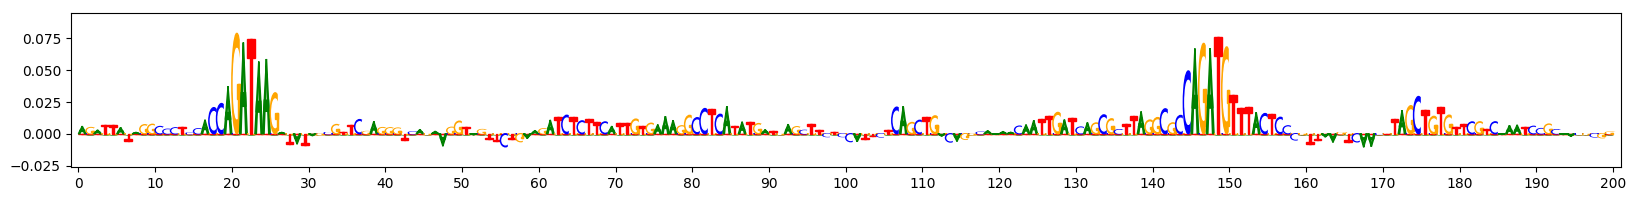

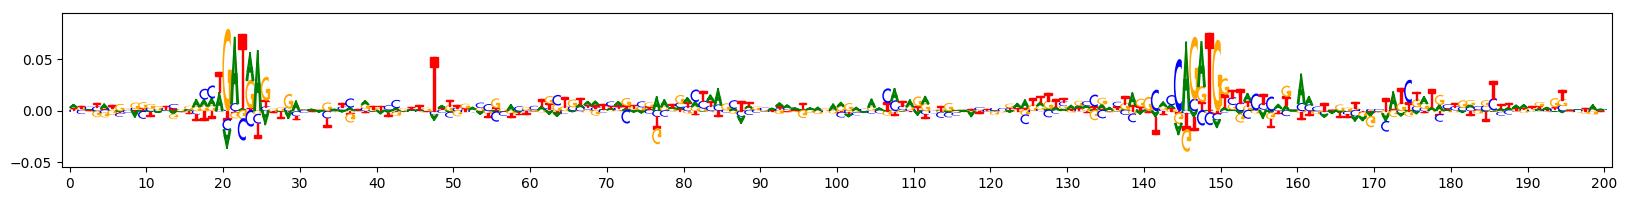

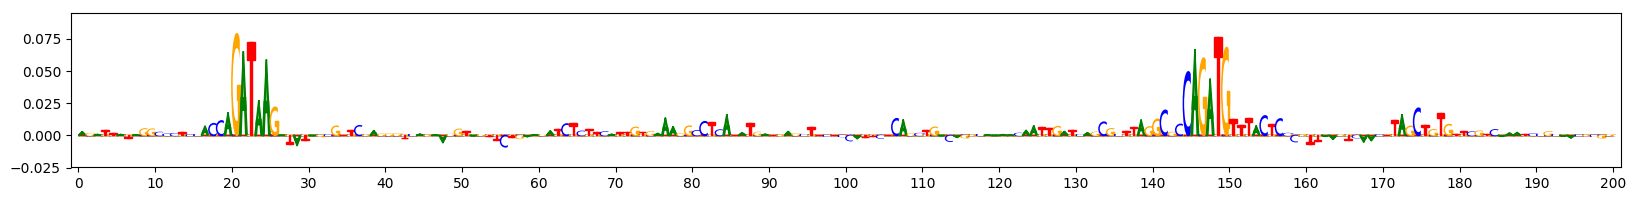

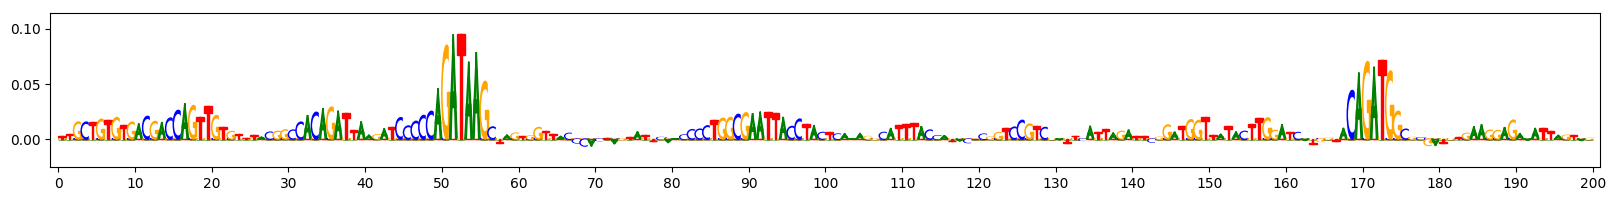

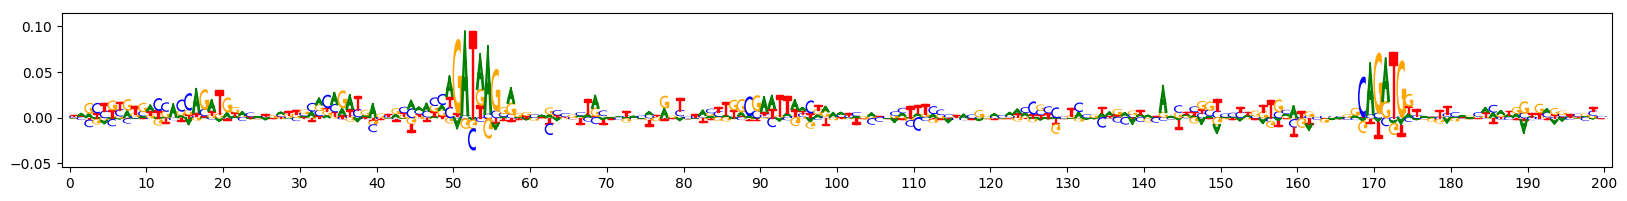

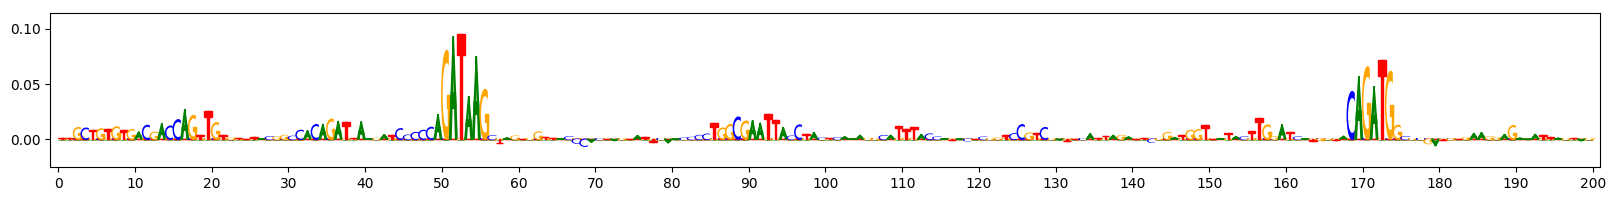

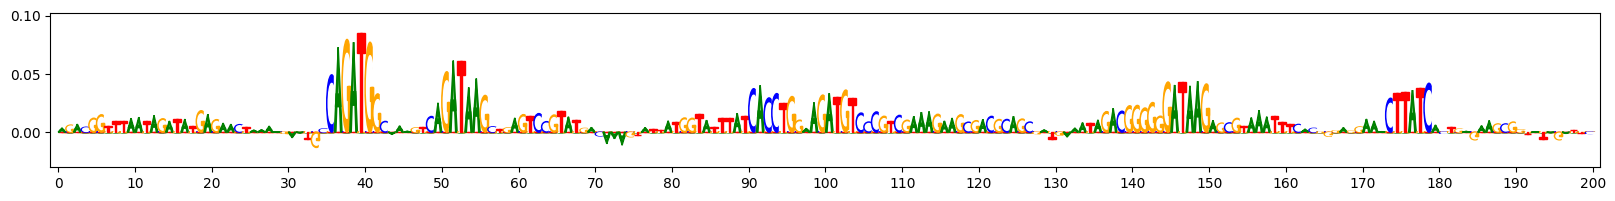

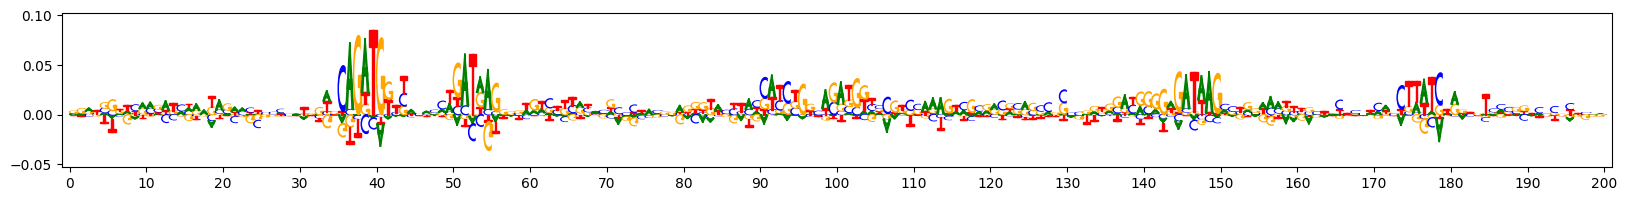

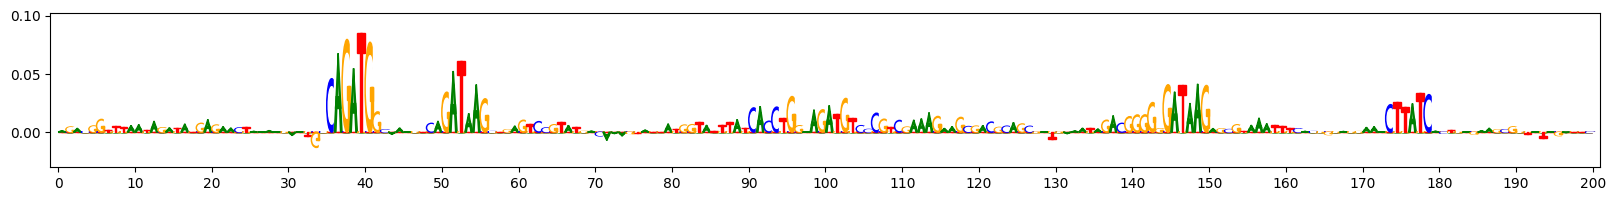

In [0]:
!pip install vizsequence
import vizsequence
from vizsequence import viz_sequence
for i in range(3):
  viz_sequence.plot_weights(impscores[i], subticks_frequency=10)
  
  
  #normalize the hyp scores such that, at each position, hypothetical importance
  # scores that have the same sign as the original importance score all sum
  # up to the original importance score value. The rationale is that if
  # a different base at the same position could produce a score of higher
  # magnitude than the base that is actually present, then the base
  # that is actually present is relatively less important.
  #Empirically, hypothetical scores like these appear to work better for
  # motif discovery.
  imp_score_each_pos = np.sum(impscores[i],axis=-1)
  imp_score_sign_each_pos = np.sign(imp_score_each_pos)
  hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])*imp_score_sign_each_pos[:,None] > 0)
  #print(hyp_scores_same_sign_mask)
  hyp_scores_same_sign_imp_scores_sum = np.sum(hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
  norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
  #print(hyp_scores_same_sign_imp_scores_sum)
  norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
  
  viz_sequence.plot_weights(norm_hyp, subticks_frequency=10)
  viz_sequence.plot_weights(norm_hyp*onehot_data[i], subticks_frequency=10)


# Motif discovery with TF-MoDISco

In [0]:
#Install TF-MoDISco for motif discovery from importance scores
#See https://github.com/kundajelab/tfmodisco for more details
!pip install modisco==0.4.2.3

  Using cached https://files.pythonhosted.org/packages/ef/fb/406180b9666f466bd8fa3d376bdd5b1eeb8132086b78d042224e41354ea1/modisco-0.4.2.3.tar.gz
  Running setup.py bdist_wheel for modisco ... - done
  Stored in directory: /root/.cache/pip/wheels/48/70/7c/614f2d0c8c6913bbfd15a546504b931ad6047559a3f3efc0c8
Successfully built modisco


On task task0
Computing windowed sums
Computing threshold
peak(mu)= 0.008778671362325532
Manually adjusting thresholds to get desired num seqlets
Mu: 8.778671e-03 +/- 3.428530e-07
Lablace_b: 0.01452183924071908 and 0.04284258406174833
Thresholds: -0.11842690454320041 and 0.13598424726785147
#fdrs pass: 0 and 3630
CDFs: 0.9998430534128147 and 0.9486524849614909
Est. FDRs: 1.0 and 0.04999783122892747


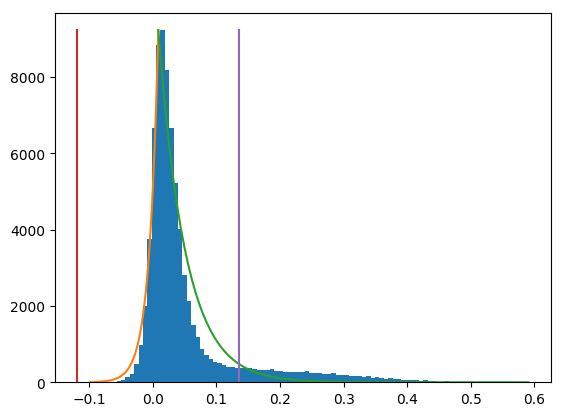

Got 1234 coords
After resolving overlaps, got 1234 seqlets
Across all tasks, the weakest laplace threshold used was: 0.948652384961491
1234 identified in total
Reducing weak_threshold_for_counting_sign to match laplace_threshold_cdf, from 0.99 to 0.948652384961491
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [1234]
Idx to activities:  {0: '1'}
On metacluster 0
Metacluster size 1234
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 1234
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings


Using TensorFlow backend.


Finished embedding computation in 1.18 s
Starting affinity matrix computations
Normalization computed in 0.05 s
Cosine similarity mat computed in 0.34 s
Normalization computed in 0.04 s
Cosine similarity mat computed in 0.32 s
Finished affinity matrix computations in 0.68 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.1 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job
Job completed in: 13.9 s
Launching nearest neighbors affmat calculation job
Job completed in: 7.27 s
(Round 1) Computed affinity matrix on nearest neighbors in 22.56 s
Filtered down to 1211 of 1234
(Round 1) Retained 1211 rows out of 1234 after filtering
(Round 1) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1211 samples in 0.002s...
[t-SNE] Computed neighbors for 1211 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1211
[t-SNE] Computed cond

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.2s finished


Louvain completed 200 runs in 7.4290060997 seconds
Wrote graph to binary file in 0.185883998871 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.824862
After 41 runs, maximum modularity is Q = 0.837096
Louvain completed 91 runs in 3.86891198158 seconds
Preproc + Louvain took 11.6600790024 s
Got 11 clusters after round 1
Counts:
{0: 223, 1: 181, 2: 169, 3: 155, 4: 150, 5: 79, 6: 57, 7: 54, 8: 53, 9: 48, 10: 42}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 223 seqlets
Trimmed 1 out of 223
Skipped 1 seqlets
Aggregating for cluster 1 with 181 seqlets
Trimmed 17 out of 181
Skipped 5 seqlets
Aggregating for cluster 2 with 169 seqlets


/usr/local/lib/python2.7/dist-packages/modisco/core.py:978: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[:,None]),
/usr/local/lib/python2.7/dist-packages/modisco/core.py:980: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[::-1,None]),


Trimmed 9 out of 169
Skipped 5 seqlets
Aggregating for cluster 3 with 155 seqlets
Trimmed 3 out of 155
Skipped 4 seqlets
Aggregating for cluster 4 with 150 seqlets
Trimmed 1 out of 150
Aggregating for cluster 5 with 79 seqlets
Trimmed 0 out of 79
Aggregating for cluster 6 with 57 seqlets
Trimmed 0 out of 57
Skipped 1 seqlets
Aggregating for cluster 7 with 54 seqlets
Trimmed 0 out of 54
Aggregating for cluster 8 with 53 seqlets
Trimmed 2 out of 53
Aggregating for cluster 9 with 48 seqlets
Trimmed 0 out of 48
Aggregating for cluster 10 with 42 seqlets
Trimmed 1 out of 42
(Round 2) num seqlets: 1161
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.67 s
Starting affinity matrix computations
Normalization computed in 0.04 s
Cosine similarity mat computed in 0.29 s
Normalization computed in 0.04 s
Cosine similarity mat computed in 0.29 s
Finished affinity matrix computations in 0.6 s
(Round 2) Compute nearest neighbors

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.2s finished


Louvain completed 200 runs in 7.31087112427 seconds
Wrote graph to binary file in 0.177653074265 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.821834
After 7 runs, maximum modularity is Q = 0.838418
Louvain completed 57 runs in 2.48902893066 seconds
Preproc + Louvain took 10.1250319481 s
Got 11 clusters after round 2
Counts:
{0: 221, 1: 158, 2: 155, 3: 149, 4: 149, 5: 71, 6: 62, 7: 56, 8: 51, 9: 48, 10: 41}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 221 seqlets
Trimmed 0 out of 221
Aggregating for cluster 1 with 158 seqlets
Trimmed 0 out of 158
Aggregating for cluster 2 with 155 seqlets
Trimmed 0 out of 155
Aggregating for cluster 3 with 149 seqlets
Trimmed 0 out of 149
Aggregating for cluster 4 with 149 seqlets
Trimmed 0 out of 149
Aggregating for cluster 5 with 71 seqlets
Trimmed 0 out of 71
Aggregating for cluster 6 with 62 seqlets
Trimmed 0 out of 62
Aggregating for cluster 7 with 56 seqlets
Trimmed 0 out

In [0]:
import modisco


#normalize the hyp scores such that, at each position, hypothetical importance
# scores that have the same sign as the original importance score all sum
# up to the original importance score value. The rationale is that if
# multiple different bases at a position could produce a similar score,
# the specific identity of each individual base is less important.
#Empirically, hypothetical scores like these appear to work better for
# motif discovery. Using normalized importance scores derived by taking
# the elementwise product of the normalized hypothetical scores and
# the one-hot encoding also seems to reduce noise.
normed_hyp_scores = []
normed_impscores = []
for i in range(len(impscores)):
  imp_score_each_pos = np.sum(impscores[i],axis=-1)
  imp_score_sign_each_pos = np.sign(imp_score_each_pos)
  hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])*imp_score_sign_each_pos[:,None] > 0)
  hyp_scores_same_sign_imp_scores_sum = np.sum(hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
  norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
  norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
  normed_hyp_scores.append(norm_hyp)
  normed_impscores.append(norm_hyp*onehot_data[i])
  
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                        #Adjust sliding_window_size and flank_size according to how big you expect
                        # the core motif to be; default values are 21 and 10
                        sliding_window_size=6,
                        flank_size=2,
                        #Unfortunately, at the time of writing,
                        # min_seqlets_per_task is not the actual number of seqlets
                        # that will end up being produced per task, but it
                        # serves as a rough target
                        #The reason for the difference is that many candidate seqlet windows
                        # will get discarded due to overlap with other windows
                        # and it's hard to predict how many
                        #The code is still in development, so I will likely
                        # refine this option later to correspond to the actual
                        # minimum number of seqlets produced per task
                        min_seqlets_per_task=3000,
                        seqlets_to_patterns_factory=modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Adjust trim_to_window_size and initial_flank_to_add
                        # according to how big you expect
                        # the core motif to be; default value is 10
                        trim_to_window_size=6,
                        initial_flank_to_add=2,
                        final_flank_to_add=5,
                        #kmer_len, num_gaps and num_mismatches are used to
                        # derive kmer embeddings for coarse-grained affinity
                        # matrix calculation. kmer_len=6, num_gaps=1
                        # and num_mismatches=0 means
                        # that kmer embeddings using 6-mers with 1 gap will be
                        # used.
                        kmer_len=6, num_gaps=1,
                        num_mismatches=0,
                        ),
                   )(
                task_names=["task0"],
                contrib_scores={'task0': normed_impscores},                
                hypothetical_contribs={'task0': normed_hyp_scores},
                one_hot=onehot_data)

('num seqlets', 592)
fwd


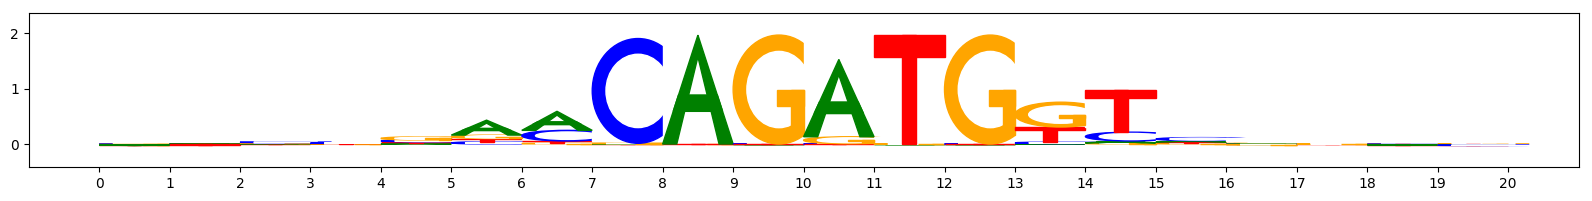

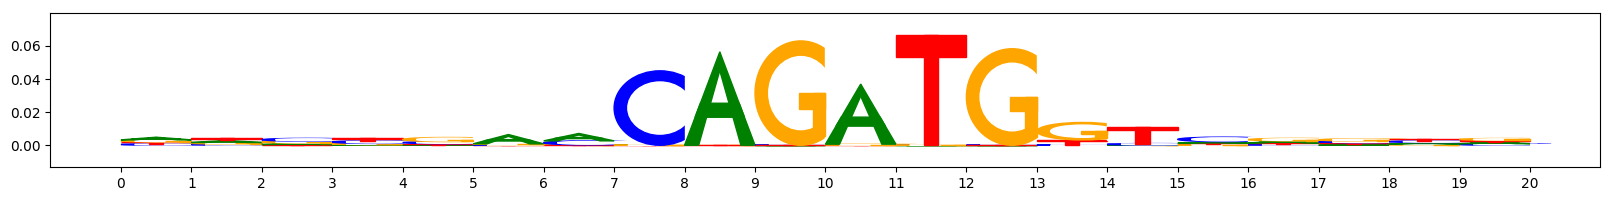

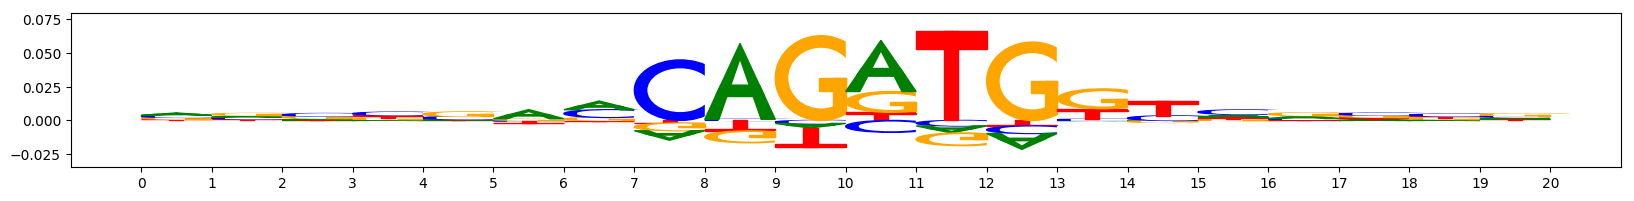

rev


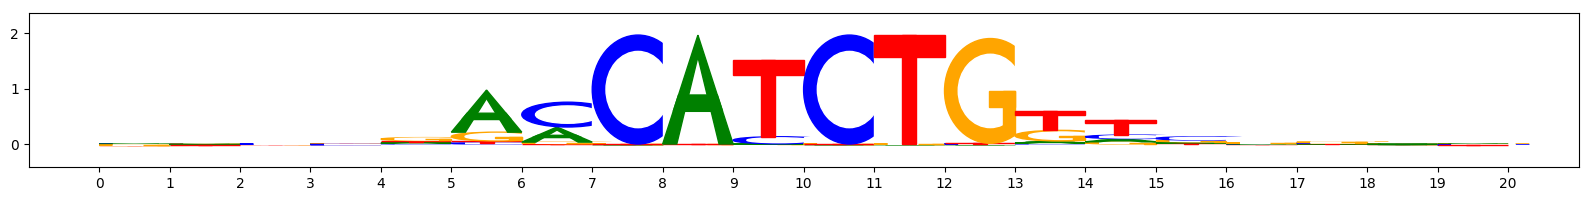

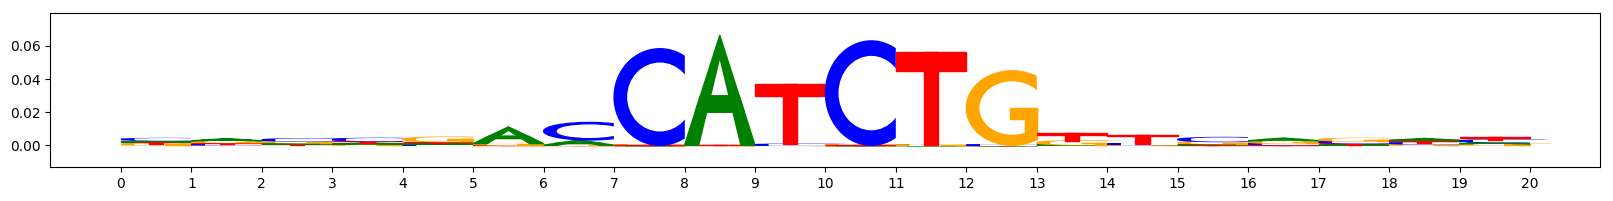

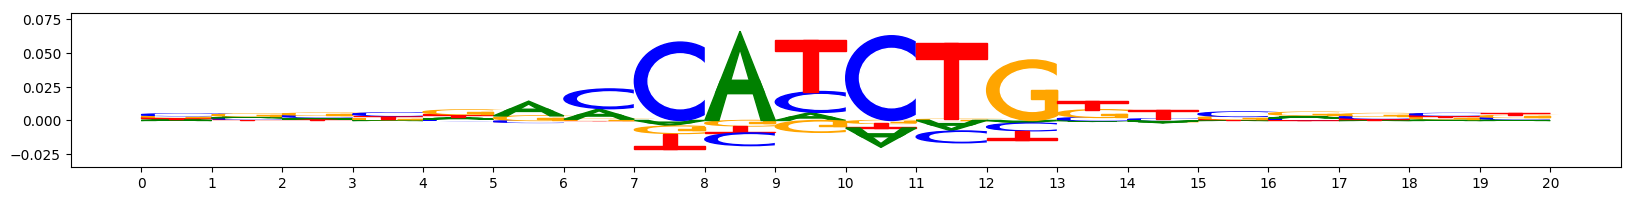

('num seqlets', 536)
fwd


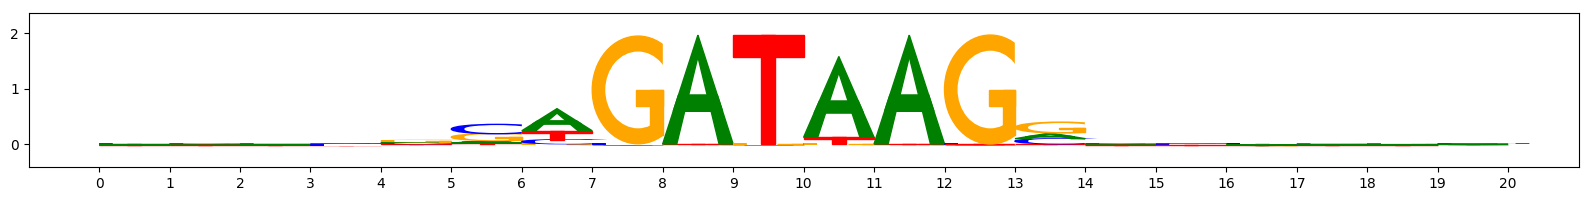

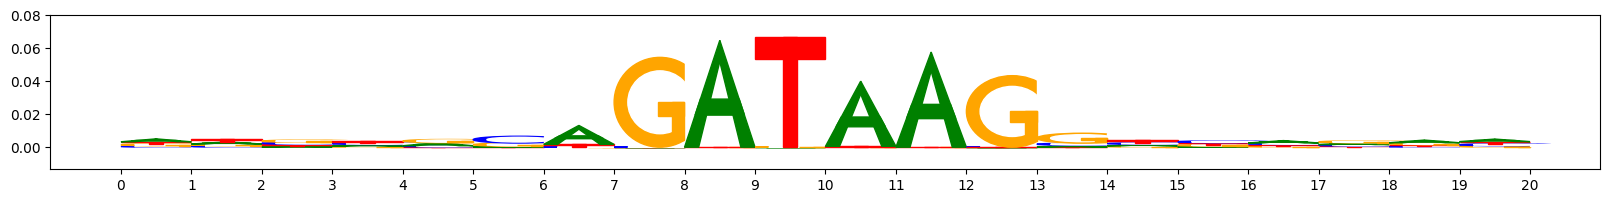

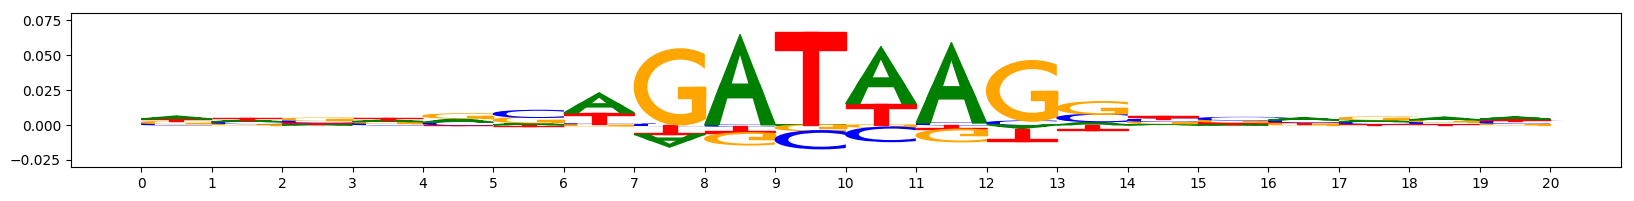

rev


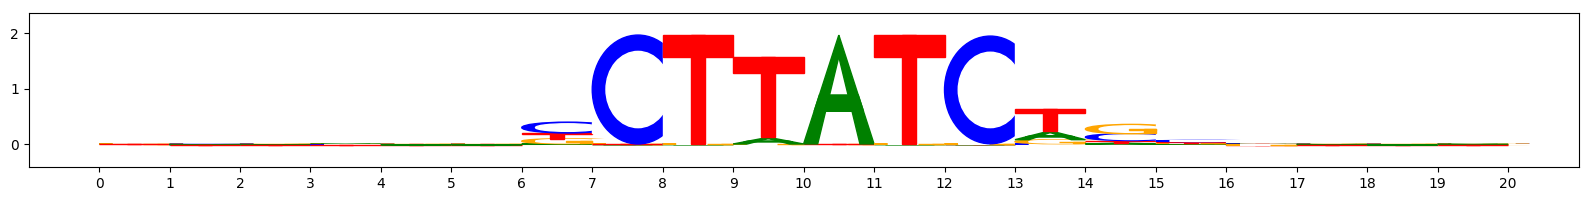

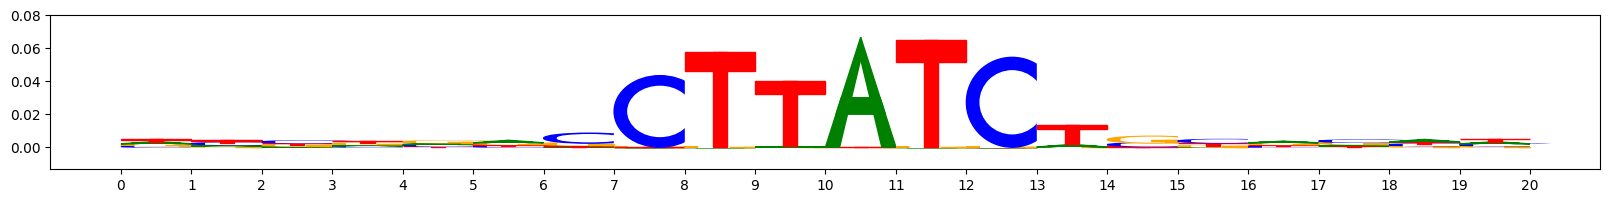

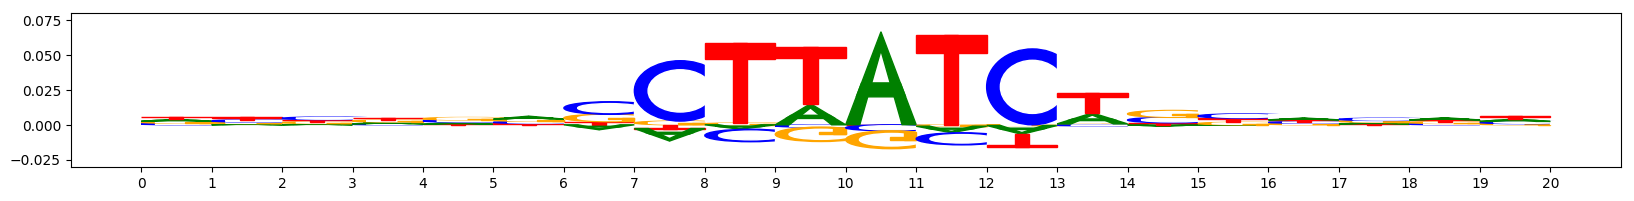

In [0]:
for i,pattern in enumerate(tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result.patterns):
  print("num seqlets",len(pattern.seqlets))
  print("fwd")
  viz_sequence.plot_weights(viz_sequence.ic_scale(
      pattern["sequence"].fwd, background=np.array([0.3,0.2,0.2,0.3])))
  viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
  
  print("rev")
  viz_sequence.plot_weights(viz_sequence.ic_scale(
      pattern["sequence"].rev, background=np.array([0.3,0.2,0.2,0.3])))
  viz_sequence.plot_weights(pattern["task0_contrib_scores"].rev)
  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)

## Comparison to PWM discovery method in Gandhi et al. (2014)

Gandhi et al. describe the following method to learn a PWM from a SVM:

We developed a new method for building de novo PWMs by systematically merging the most predictive k-mers from a trained gkm-SVM. We first determined a set of predictive k-mers by scoring all possible 10-mers and selecting the top 1% of the high-scoring 10-mers. We then found a set of distinct PWM models from these predictive 10-mers using a heuristic iterated greedy algorithm. Specifically, we first built an initial PWM model from the highest scoring 10-mer. Then, for each of the remaining predictive 10-mers, we calculated the log-odd ratios of all possible alignments of the 10-mer to the PWM model, and identified the best alignment (i.e. the position and the orientation that give rise to the highest log-odd ratio value). Since multiple distinct classes of TFBSs are expected to be identified in most cases, we only considered 10-mers with good alignments (i.e. we used threshold of 5.0 for log-odd ratio scores relative to a genomic GC = 0.42 background). After each of the 10-mers was aligned, we updated the PWM model only with successfully aligned 10-mers. To further refine the PWM, we repeated this by iterating through all of the top 1% 10-mers until no changes were made. When updating the PWM model, we assumed that the contribution of each k-mer is exponentially weighted proportional to its SVM score, using exp(α wi), with α = 3.0. The 10-mers used for creating the 1st PWM were then removed from the list, and the process was repeated on the remaining predictive k-mers, to find up to three PWMs. Lastly, we matched our PWMs to the previously identified PWMs [18] using TOMTOM [36] software. Each of the PWMs identified by our method were associated with Ref. [18] PWMs if the q-value (false discovery rate) <0.05.

The code for this can be downloaded from the gkmsvm website, which we have done here

In [0]:
!wget http://www.beerlab.org/gkmsvm/downloads/gkmsvm-2.0.tar.gz -O gkmsvm-2.0.tar.gz
!tar -xzf gkmsvm-2.0.tar.gz

--2019-01-27 11:14:26--  http://www.beerlab.org/gkmsvm/downloads/gkmsvm-2.0.tar.gz
Resolving www.beerlab.org (www.beerlab.org)... 23.229.186.73
Connecting to www.beerlab.org (www.beerlab.org)|23.229.186.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2936492 (2.8M) [application/x-gzip]
Saving to: ‘gkmsvm-2.0.tar.gz.1’

gkmsvm-2.0.tar.gz.1 100%[===================>]   2.80M   863KB/s    in 3.3s    

2019-01-27 11:14:29 (863 KB/s) - ‘gkmsvm-2.0.tar.gz.1’ saved [2936492/2936492]



In [0]:
#Generate all possible non-redundant 10-mers
!python gkmsvm/scripts/nrkmers.py 10 nrkmers.fa

In [0]:
#score the non-redundant kmers using the model
!lsgkm/src/gkmpredict nrkmers.fa $model_file nrkmers_scores.txt -v 1

In [0]:
#generate the PWMs using the provided script with default settings
# it was unclear to us what to set for PWM_LENGTH based on the description
# of the algorithm in Gandhi et al., so we set it to 12 given that the
# core of the embedded TAL and GATA motifs are around 6bp each, and
# 6-mers were used to train the model
!python gkmsvm/scripts/svmw_emalign.py nrkmers_scores.txt 12 gandhietalpwms

INFO  @ Sun, 27 Jan 2019 11:18:16: seed kmer: CCATCTTATC 
INFO  @ Sun, 27 Jan 2019 11:18:16: round - 0/100 
INFO  @ Sun, 27 Jan 2019 11:18:17: obj: 831.003538 
INFO  @ Sun, 27 Jan 2019 11:18:17: round - 1/100 
INFO  @ Sun, 27 Jan 2019 11:18:17: obj: 196.343612 
INFO  @ Sun, 27 Jan 2019 11:18:17: round - 2/100 
gkmsvm/scripts/svmw_emalign.py:264: RuntimeWarning: invalid value encountered in divide
  model = model / row_sums[:, numpy.newaxis]
INFO  @ Sun, 27 Jan 2019 11:18:17: obj: 0.000000 
INFO  @ Sun, 27 Jan 2019 11:18:17: round - 3/100 
INFO  @ Sun, 27 Jan 2019 11:18:18: obj: 0.000000 
INFO  @ Sun, 27 Jan 2019 11:18:18: skip CCATCTTATC (number of kmers aligned is 0 < 100) 
INFO  @ Sun, 27 Jan 2019 11:18:18: seed kmer: GATAAGATGG 
INFO  @ Sun, 27 Jan 2019 11:18:18: round - 0/100 
INFO  @ Sun, 27 Jan 2019 11:18:18: obj: 811.324924 
INFO  @ Sun, 27 Jan 2019 11:18:18: round - 1/100 
INFO  @ Sun, 27 Jan 2019 11:18:18: obj: 226.944610 
INFO  @ Sun, 27 Jan 2019 11:18:18: round - 2/100 
INFO

### The method of Gandhi et al. (2014) failed to produce motifs

In [0]:
#visualize the resulting motifs

!cat gandhietalpwms_models.meme

MEME version 4

ALPHABET= ACGT

strands: + -

Background letter frequencies (from entire human genome)
A 0.29 C 0.21 G 0.21 T 0.29



# Comparison to ISM

In [0]:
the_seq = "ATGGAGCGATAAGCAAGCAGCGTTAAAATTTGAACTGCCGTATATGCATCCTCTCCTTGATAAGCCCTTCAGCTTCGTAACTGTAATGCCACTCTCGAGGTTAACGATAAGGGAGACGAATCTCGTACTATTAGCGTAGGCTTGTCTTCTAAACTCTTATAAGAGTCAGATGCCTATAAGGTCGTTACAGAATTGTATCA"

In [0]:
import time 

def run_ism(model_file_path,sequence,temp_filepath):
  
  letter_to_idx = {'A':0, 'C':1, 'G':2, 'T':3, 'N': -1}
  
  fh = open(temp_filepath,'w')
  fh.write(">orig_seq\n")
  fh.write(sequence+"\n")
  fh.close()
  explanation_file = temp_filepath+".explanation.txt"
  !lsgkm/src/gkmexplain $temp_filepath $model_file_path $explanation_file
  
  gkmexplain_impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explanation_file)
  ][0]

  
  seq_len = len(sequence)
  fh = open(temp_filepath,'w')
  fh.write(">orig_seq\n")
  fh.write(sequence+"\n")
  
  onehot_seq = np.zeros((seq_len,4))  
  for pos in range(seq_len):
    orig_letter_idx = letter_to_idx[sequence[pos]]
    if (orig_letter_idx != -1):
      onehot_seq[pos,orig_letter_idx] = 1
    for letter in ['A','C','G','T']:
      #only need to compute scores for perturbations
      if (letter != sequence[pos]):
        letter_idx = letter_to_idx[letter]
        fh.write(">pos-"+str(pos)+"_base-"+str(letter_idx)+"\n")
        fh.write(sequence[:pos]+letter+sequence[pos+1:]+"\n")
  fh.close()
  
  start = time.time()
  predictions_file = temp_filepath+".preds.txt"
  !lsgkm/src/gkmpredict $temp_filepath $model_file_path $predictions_file
  print("Time taken for all ISM predictions",time.time()-start)
    
  ism_importance_scores = np.zeros((seq_len,4))
  for line in open(predictions_file):
    seq_name,pred = line.rstrip().split("\t")
    pred = float(pred)
    if (seq_name=="orig_seq"):
      orig_pred = pred
    else:
      pos,letter_idx = seq_name.split("_")
      pos = int(pos.split("-")[1])
      letter_idx = int(letter_idx.split("-")[1])
      ism_importance_scores[pos,letter_idx] = (pred - orig_pred)
  
  !rm $temp_filepath
  !rm $predictions_file
  !rm $explanation_file
  
  ism_hyp_importance_scores = ism_importance_scores-np.mean(ism_importance_scores,axis=1)[:,None]
  ism_importance_scores = ism_hyp_importance_scores*onehot_seq
  
  return ism_importance_scores, ism_hyp_importance_scores, gkmexplain_impscores
  


INFO 2019-01-27 21:46:02: Number of threads is set to 1
INFO 2019-01-27 21:46:02: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2019-01-27 21:46:02: reading... 1000/4452
INFO 2019-01-27 21:46:02: reading... 2000/4452
INFO 2019-01-27 21:46:03: reading... 3000/4452
INFO 2019-01-27 21:46:03: reading... 4000/4452
INFO 2019-01-27 21:46:03: write prediction result to tmp.explanation.txt
INFO 2019-01-27 21:46:03: 1 scored
INFO 2019-01-27 21:46:04: Number of threads is set to 1
INFO 2019-01-27 21:46:04: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2019-01-27 21:46:05: reading... 1000/4452
INFO 2019-01-27 21:46:05: reading... 2000/4452
INFO 2019-01-27 21:46:05: reading... 3000/4452
INFO 2019-01-27 21:46:05: reading... 4000/4452
INFO 2019-01-27 21:46:05: write prediction result to tmp.preds.txt
INFO 2019-01-27 21:46:06: 100 scored
INFO 2019-01-27 21:46:06: 200 scored
INFO 2019-01-27 21:46:07: 300 scored
INFO 2019-01-27 21:46:08: 400 scored
INFO 2019-01-27 21:46:08: 500 scored


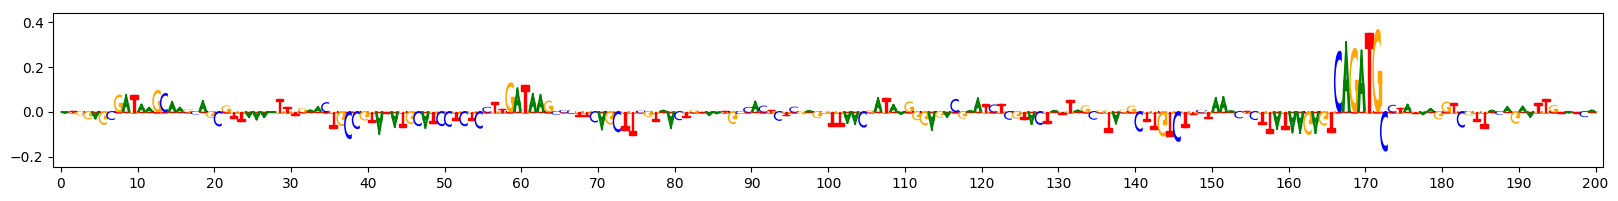

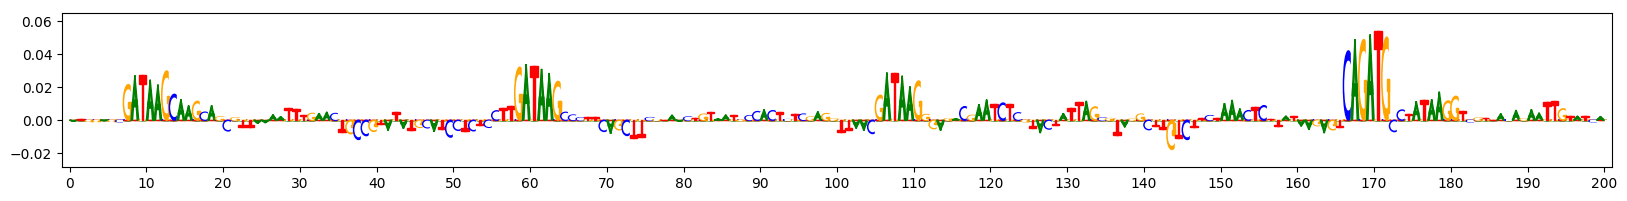

In [0]:
ism_scores, ism_hyp_imp_scores, gkmexplain_scores = run_ism(model_file_path=model_file,
        sequence=the_seq, temp_filepath="tmp")

viz_sequence.plot_weights(ism_scores, subticks_frequency=10)
viz_sequence.plot_weights(gkmexplain_scores, subticks_frequency=10)

# Comparison to deltaSVM

In [0]:
!python lsgkm/scripts/nrkmers.py 6 kmers.fa

In [0]:
!lsgkm/src/gkmpredict kmers.fa $model_file preds_kmers.txt

INFO 2019-01-27 11:04:30: Number of threads is set to 1
INFO 2019-01-27 11:04:30: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2019-01-27 11:04:30: reading... 1000/4452
INFO 2019-01-27 11:04:30: reading... 2000/4452
INFO 2019-01-27 11:04:30: reading... 3000/4452
INFO 2019-01-27 11:04:30: reading... 4000/4452
INFO 2019-01-27 11:04:30: write prediction result to preds_kmers.txt
INFO 2019-01-27 11:04:30: 100 scored
INFO 2019-01-27 11:04:30: 200 scored
INFO 2019-01-27 11:04:31: 300 scored
INFO 2019-01-27 11:04:31: 400 scored
INFO 2019-01-27 11:04:31: 500 scored
INFO 2019-01-27 11:04:31: 600 scored
INFO 2019-01-27 11:04:31: 700 scored
INFO 2019-01-27 11:04:31: 800 scored
INFO 2019-01-27 11:04:31: 900 scored
INFO 2019-01-27 11:04:31: 1000 scored
INFO 2019-01-27 11:04:31: 1100 scored
INFO 2019-01-27 11:04:31: 1200 scored
INFO 2019-01-27 11:04:31: 1300 scored
INFO 2019-01-27 11:04:31: 1400 scored
INFO 2019-01-27 11:04:31: 1500 scored
INFO 2019-01-27 11:04:31: 1600 scored
INFO 2019-01

In [0]:
deltasvm_kmer_to_pred = {}
rc_trans = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
for line in open("preds_kmers.txt"):
  kmer,pred = line.rstrip().split("\t")
  pred = float(pred)
  deltasvm_kmer_to_pred[kmer] = pred
  deltasvm_kmer_to_pred["".join([rc_trans[x] for x in kmer[::-1]])] = pred
  
def deltasvm_scores(sequence, deltasvm_kmer_to_pred, lmersize):
  
  onehot_sequence = np.zeros((len(sequence),4))
  scores = np.zeros((len(sequence),4))
  for (i,base) in enumerate(sequence):
    if (i <= len(sequence)-lmersize):
      lmer = sequence[i:i+lmersize]
      lmer_pred = deltasvm_kmer_to_pred[lmer]
      for (j,lmer_base) in enumerate(lmer):
        for base_idx,base_sub in enumerate(['A','C','G','T']):
          if base_sub!=lmer_base:
            new_lmer = lmer[:j]+base_sub+lmer[(j+1):]
            new_pred = deltasvm_kmer_to_pred[new_lmer]
            delta = new_pred - lmer_pred
            scores[i+j, base_idx] = delta
          else:
            onehot_sequence[i+j, base_idx] = 1
  scores = scores - np.mean(scores,axis=1)[:,None]
  return scores*onehot_sequence, scores
  

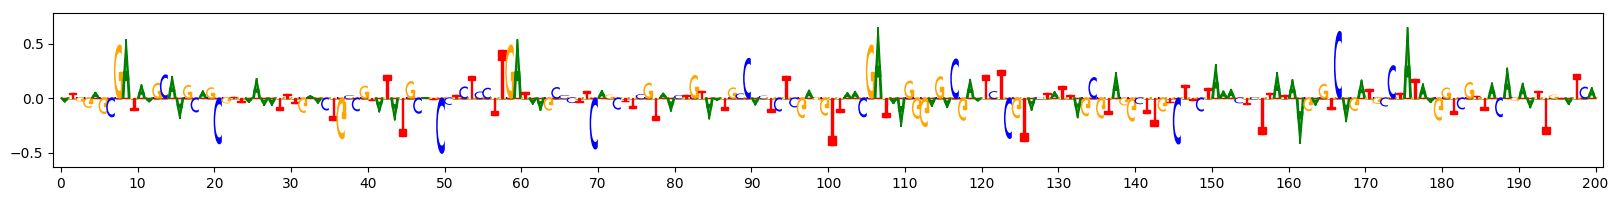

In [0]:
delta_svm_scores, delta_svm_hypscores = deltasvm_scores(the_seq, deltasvm_kmer_to_pred, 6)
viz_sequence.plot_weights(delta_svm_scores, subticks_frequency=10)

# Comparison to SHAP

(200,)
2000
(200, 200)
('tmp', 'params_t3_l6_k5_d1_g2_c10_w3.model.txt', 'tmp_preds')
INFO 2019-01-27 21:49:08: Number of threads is set to 1
INFO 2019-01-27 21:49:08: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2019-01-27 21:49:09: reading... 1000/4452
INFO 2019-01-27 21:49:09: reading... 2000/4452
INFO 2019-01-27 21:49:09: reading... 3000/4452
INFO 2019-01-27 21:49:09: reading... 4000/4452
INFO 2019-01-27 21:49:09: write prediction result to tmp_preds
INFO 2019-01-27 21:49:10: 100 scored
INFO 2019-01-27 21:49:11: 200 scored


No handlers could be found for logger "shap"


(1, 200)
('tmp', 'params_t3_l6_k5_d1_g2_c10_w3.model.txt', 'tmp_preds')
INFO 2019-01-27 21:49:12: Number of threads is set to 1
INFO 2019-01-27 21:49:12: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2019-01-27 21:49:12: reading... 1000/4452
INFO 2019-01-27 21:49:12: reading... 2000/4452
INFO 2019-01-27 21:49:12: reading... 3000/4452
INFO 2019-01-27 21:49:12: reading... 4000/4452
INFO 2019-01-27 21:49:13: write prediction result to tmp_preds
INFO 2019-01-27 21:49:13: 1 scored
(400000, 200)
('tmp', 'params_t3_l6_k5_d1_g2_c10_w3.model.txt', 'tmp_preds')
INFO 2019-01-27 21:49:34: Number of threads is set to 1
INFO 2019-01-27 21:49:34: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2019-01-27 21:49:34: reading... 1000/4452
INFO 2019-01-27 21:49:35: reading... 2000/4452
INFO 2019-01-27 21:49:35: reading... 3000/4452
INFO 2019-01-27 21:49:35: reading... 4000/4452
INFO 2019-01-27 21:49:35: write prediction result to tmp_preds
INFO 2019-01-27 21:49:36: 100 scored
INFO 2019-01-

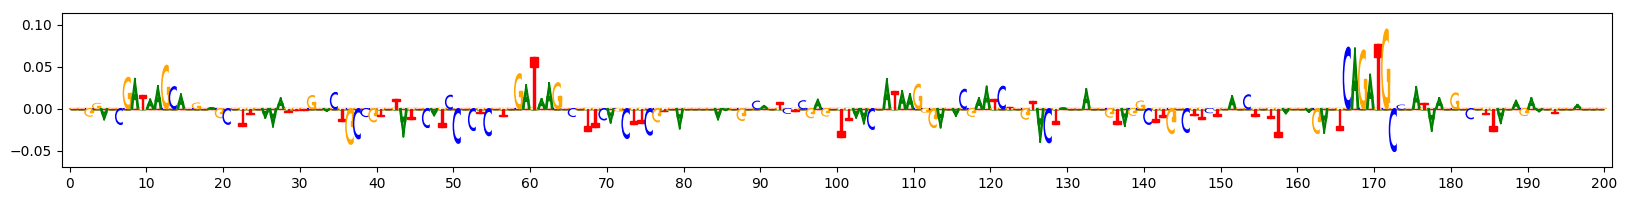

In [0]:
!pip install shap
!pip install deeplift
!pip install vizsequence

from matplotlib import pyplot as plt
plt.style.use('default')

import vizsequence
from vizsequence import viz_sequence

import shap
import numpy as np
import sys
import deeplift
from deeplift import dinuc_shuffle
import time
import random


def onehot_seq(seq):
  letter_to_index = {'A':0, 'a':0,
                     'C':1, 'c':1,
                     'G':2, 'g':2,
                     'T':3, 't':3}
  to_return = np.zeros((len(seq),4))
  for idx,letter in enumerate(seq):
    to_return[idx,letter_to_index[letter]] = 1
  return to_return


def get_shap_explanation(gkmsvm_model_path,
                         seq, background_seqs,
                         tempfile, nsamples):
  
  index_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
  letter_to_index = dict([(y,x) for (x,y) in index_to_letter.items()])
  
  def pred_func(numerically_encoded_seqs):
    print(numerically_encoded_seqs.shape)
    #convert the sequences to strings]
    seqs = ["".join(index_to_letter[x] for x in seq)
            for seq in numerically_encoded_seqs]
    
    fh = open(tempfile, "w");
    for i,seq in enumerate(seqs):
      fh.write(">seq"+str(i)+"\n")
      fh.write(seq+"\n")
    fh.close()
    
    model_preds = tempfile+"_preds"
    print(tempfile, gkmsvm_model_path, model_preds)
    
    !lsgkm/src/gkmpredict $tempfile $gkmsvm_model_path $model_preds
    
    return np.array([float(x.rstrip().split("\t")[1])
                     for x in open(model_preds)])
  
  
  X_test = np.array([letter_to_index[x] for x in seq])
  print(X_test.shape)
  print(nsamples)
  
  explainer = shap.KernelExplainer(pred_func,
                                   np.array(
                                   [[letter_to_index[x] for x in seq]
                                    for seq in background_seqs]
                                   ))
  shap_values = explainer.shap_values(X_test,
                                      nsamples=nsamples)
  return shap_values

#nsamplesandbg_to_explanation = {}
#nsamplesandbg_to_time_taken = {}

for (nsamples_multiplier,n_bg) in [#(1,20),
                                   #(5,20),
                                   #(10,20),
                                   #(100,20),
                                   (10,200)]:

  nsamples = len(the_seq)*nsamples_multiplier
  start = time.time()
  np.random.seed(1234)
  random.seed(1234)
  shap_explanation = get_shap_explanation(
      gkmsvm_model_path=model_file,
      seq=the_seq,
      background_seqs=[
          dinuc_shuffle.dinuc_shuffle(the_seq)
          for i in range(n_bg)],
      tempfile="tmp",
      nsamples=nsamples)
  
  print("n samples",nsamples,"n bg", n_bg)
  time_taken = time.time() - start
  nsamplesandbg_to_time_taken[(nsamples,n_bg)] = time_taken
  print("Time taken:",time_taken)  
  print("Num samples:",nsamples,"bg size",n_bg)
  explanation = shap_explanation[:,None]*onehot_seq(the_seq)
  nsamplesandbg_to_explanation[(nsamples,n_bg)] = explanation
  viz_sequence.plot_weights(explanation, subticks_frequency=10)

(200, 'samples', 'bg', 20, 'time taken', 28.71793794631958)


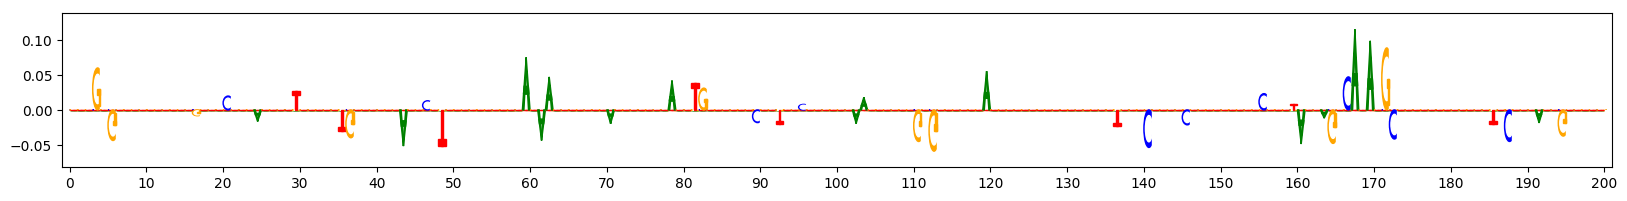

(1000, 'samples', 'bg', 20, 'time taken', 119.86875605583191)


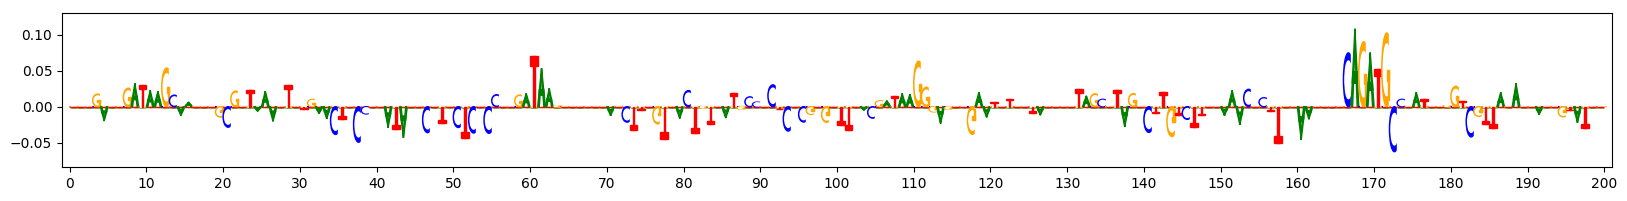

(2000, 'samples', 'bg', 20, 'time taken', 233.33230209350586)


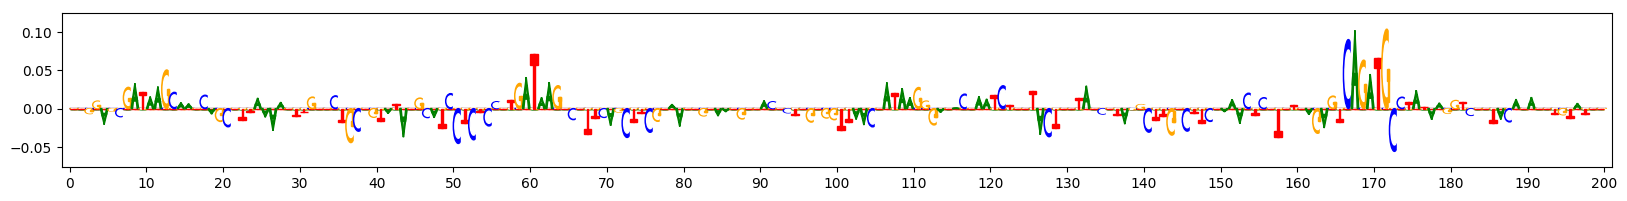

(2000, 'samples', 'bg', 200, 'time taken', 2269.3596589565277)


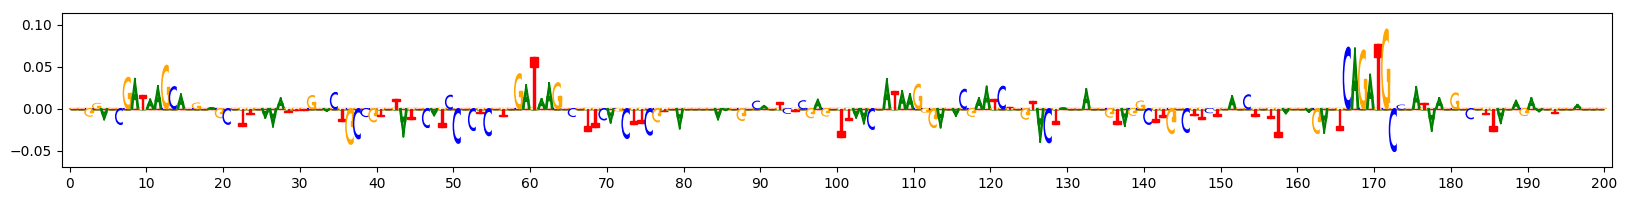

(20000, 'samples', 'bg', 20, 'time taken', 2277.9176738262177)


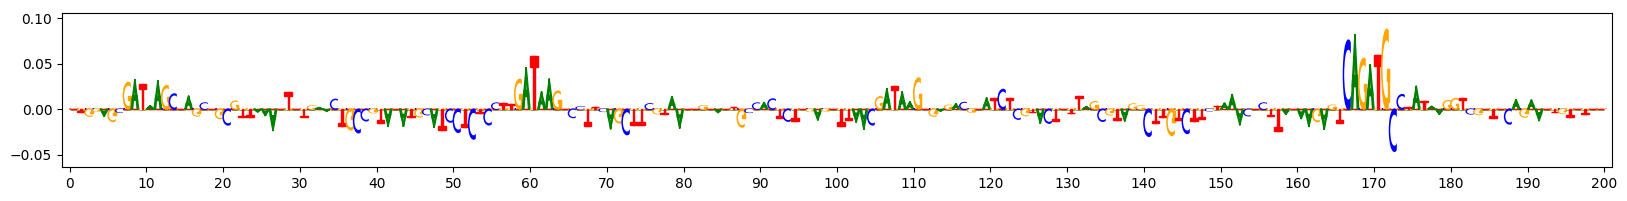

In [0]:
for nsamples,n_bg in sorted(nsamplesandbg_to_explanation.keys()):
  print(nsamples,"samples","bg",n_bg,"time taken",nsamplesandbg_to_time_taken[(nsamples,n_bg)])
  viz_sequence.plot_weights(nsamplesandbg_to_explanation[(nsamples,n_bg)], subticks_frequency=10)

In [8]:
#benchmark runtime of predict
!cat negatives.fa positives.fa > all.fa
start = time.time()
!lsgkm/src/gkmpredict all.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_all.txt
end = time.time()
print("Time taken per seq:",(end-start)/16000)

INFO 2019-01-28 00:21:17: Number of threads is set to 1
INFO 2019-01-28 00:21:17: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2019-01-28 00:21:17: reading... 1000/4452
INFO 2019-01-28 00:21:17: reading... 2000/4452
INFO 2019-01-28 00:21:17: reading... 3000/4452
INFO 2019-01-28 00:21:17: reading... 4000/4452
INFO 2019-01-28 00:21:17: write prediction result to preds_all.txt
INFO 2019-01-28 00:21:18: 100 scored
INFO 2019-01-28 00:21:18: 200 scored
INFO 2019-01-28 00:21:19: 300 scored
INFO 2019-01-28 00:21:20: 400 scored
INFO 2019-01-28 00:21:20: 500 scored
INFO 2019-01-28 00:21:21: 600 scored
INFO 2019-01-28 00:21:21: 700 scored
INFO 2019-01-28 00:21:22: 800 scored
INFO 2019-01-28 00:21:22: 900 scored
INFO 2019-01-28 00:21:23: 1000 scored
INFO 2019-01-28 00:21:23: 1100 scored
INFO 2019-01-28 00:21:24: 1200 scored
INFO 2019-01-28 00:21:25: 1300 scored
INFO 2019-01-28 00:21:25: 1400 scored
INFO 2019-01-28 00:21:26: 1500 scored
INFO 2019-01-28 00:21:26: 1600 scored
INFO 2019-01-2